<a href="https://colab.research.google.com/github/ak-hannou/compsci-4ml3/blob/main/F24_4ML3_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submit your pdf report as well as your ipynb file to Avenue (separate files). Make sure your pdf report includes all the plots, results, and analyses.


# SVM and Logistic Regression with PyTorch Implementation
In this exercise, we explore a machine learning framework called PyTorch. We will use the framework to implement SVM and Logistic Regression models and address a multi-class image classification problem.

# Submission
- There are four tasks for you.
- Report the results and answer the questions in a pdf file.
- Additionally, submit your code in the same Jupiter notebook format. (keep the overal format of the notebook unchanged)

In [311]:
# Hyperparameters for training a neural network on the MNIST dataset

# Learning rate controls the step size of gradient descent, determining how much to update the weights in each iteration.
learning_rate = 0.02

# Number of epochs specifies how many complete passes through the training dataset will be performed.
num_epochs = 100

# Batch size defines the number of images processed in each mini-batch during training.
batch_size = 32

# Percentage of the dataset to be used for training, allowing for experimentation with smaller subsets of data.
train_data_percentage = 0.0025
test_data_percentage = 0.1

# Input size corresponds to the dimensions of the MNIST images, flattened from 28x28 pixels.
input_size = 28 * 28  # MNIST image size

# Number of output classes, representing the digits 0 through 9 in the MNIST dataset.
num_classes = 10  # Number of classes in MNIST

In [312]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Dataset characteristics
We use the MNIST digit classification data set for this assignment.
A total of 60K images for training and 10K images for testing are available. But we only use a small percentage of them. Images are 28 x 28 pixels.

In [313]:
# Load MNIST datasets, and create pytorch data loader to read data in mini-batches
def get_data_loaders(train_data_percentage, test_data_percentage, batch_size, transform):
    # Load the entire MNIST dataset
    # For train and test data points we sometimes use different transforms.
    # This becomes handy in the last task (data augmentation)
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_transform = transforms.Compose([transforms.ToTensor()])
    full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

    # Calculate the size based on the percentage
    train_size = int(train_data_percentage * len(full_train_dataset))  # percentage of training data
    test_size = int(test_data_percentage * len(full_test_dataset))    # percentage of test data
    train_remainder = len(full_train_dataset) - train_size
    test_remainder = len(full_test_dataset) - test_size

    # Split the dataset into the percentage specified and the remaining
    train_dataset, _ = random_split(full_train_dataset, [train_size, train_remainder])
    test_dataset, _ = random_split(full_test_dataset, [test_size, test_remainder])

    # Create DataLoaders for batching and shuffling
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [314]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.ToTensor()])
train_loader, test_loader = get_data_loaders(train_data_percentage, test_data_percentage,batch_size, transform)

In [315]:
# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image),\
 28X28 stands for WxH (width and height of a single image).')

train_loader contains 5 batches of data.
train_image_batch has shape torch.Size([32, 1, 28, 28]),
where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).


In [316]:
#ABOVE CELL COMMENT HAS 64, CODE IS SET TO 32

# Visualization of the dataset

In [317]:
def show_gray_digits(image_set, row=2, col=3):
    # Here we visualize some of the data points in the data set.
    # Create a large figure, to be filled with multiple subplots.

    # Since image_set is a tensor variable, we transform it to a numpy type variable.
    image_set = image_set.cpu().detach().numpy()

    for i in range(row*col):
      # define subplot
      plt.subplot(row, col, i+1)
      # plot raw pixel data
      plt.imshow(image_set[i,0], cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()

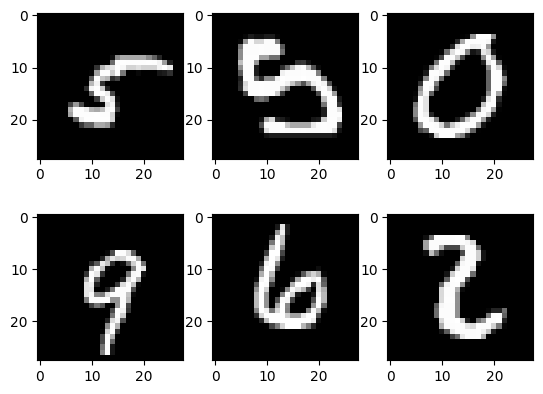

tensor([5, 5, 0, 9, 6, 2])


In [318]:
# display images and their corresponding labels.
show_gray_digits(train_image_batch, 2, 3)
print(classe_set[:6])

del train_image_batch, classe_set, train_loader, test_loader, transform

# Task 1: Linear SVM for MNIST classification (30 points).
In this part, you are provided with the implementation of a multi-class linear SVM model and the basic MNIST classfication workflow. Run the given code and try to understand how it works.

## Part A (5 points):

Is the implementation of the multi-class linear SVM similar to the end-to-end multiclass SVM that we learned in the class? Are there any significant differences?

## Part B (15 points):
1. Compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number and include it in the report (include only the plot in your report, not all the 2*100 numbers).

2. Compute the hinge loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number and include it in the report.(include only the plot in your report, not all the 2*100 numbers)

3. Report the **last** epoch results (including loss values and accuracies) for both train and test sets.

4. Does the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?

In [319]:
# Function to plot train/test loss and accuracy on separate subplots
def plot_eval_results(train_loss, test_loss, train_acc, test_acc):
    """
    Plots the training and testing loss/accuracy over the number of epochs.

    Parameters:
    - train_loss: list or array, the training loss values over epochs.
    - test_loss: list or array, the testing loss values over epochs.
    - train_acc: list or array, the training accuracy values over epochs.
    - test_acc: list or array, the testing accuracy values over epochs.
    """
    dim = np.arange(1,101,1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    
    ax1.plot(dim,train_loss, label='Train Loss')
    ax1.plot(dim,test_loss, label='Test Loss')
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend()
    ax2.plot(dim,train_acc, label='Train Accuracy')
    ax2.plot(dim,test_acc, label='Test Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()


    # Adjust layout to avoid subplot overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

In [320]:
# Define a linear SVM model
class LinearSVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(input_size, num_classes, bias=True)

    def forward(self, x):
        # Flatten the image
        x= x.view(-1, input_size)
        return self.fc(x)

In [321]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader, test_loader = get_data_loaders(train_data_percentage, test_data_percentage, batch_size, transform)

In [322]:
# Return model loss and accuracy with the provided criterion and data_loader.
def eval(model, data_loader, criterion=None):
  model.eval()
  correct = 0
  total = 0
  loss_batches = []

  # Switch to evaluation mode and turn off gradient calculation
  # since parameters are not updated during testing.
  with torch.no_grad():
      for images_batch, labels_batch in data_loader:
          outputs = model(images_batch)
          # The predicted label is the output with the highest activation.
          _, predicted = torch.max(outputs.data, 1)
          total += labels_batch.size(0)
          correct += (predicted == labels_batch).sum().item()

          # Use provided criterion to calculate the loss for the mini batch
          # Append the mini-batch loss to loss_batches array
          batch_loss = criterion(outputs, labels_batch)
          loss_batches.append(batch_loss.item())

  accuracy = 100 * correct / total
  loss = np.mean(loss_batches)

  model.train()

  return accuracy, loss

In [323]:
# Initialize the model, loss function, and optimizer
model = LinearSVM(input_size, num_classes)
criterion = nn.MultiMarginLoss()  # A Multi-class version of Hinge loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training the model
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)

    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

Epoch 01 - Train loss: 0.778057, Train accuracy: 26.67%
         - Test loss: 0.813177, Test accuracy: 20.90%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.633413, Train accuracy: 42.67%
         - Test loss: 0.707682, Test accuracy: 33.80%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.512565, Train accuracy: 50.67%
         - Test loss: 0.625326, Test accuracy: 38.80%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.438759, Train accuracy: 60.00%
         - Test loss: 0.553217, Test accuracy: 45.70%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.372953, Train accuracy: 65.33%
         - Test loss: 0.491853, Test accuracy: 51.50%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.321337, Train accuracy: 68.67%
         - Test loss: 0.443266, Test accuracy: 54.70%
------------------------------

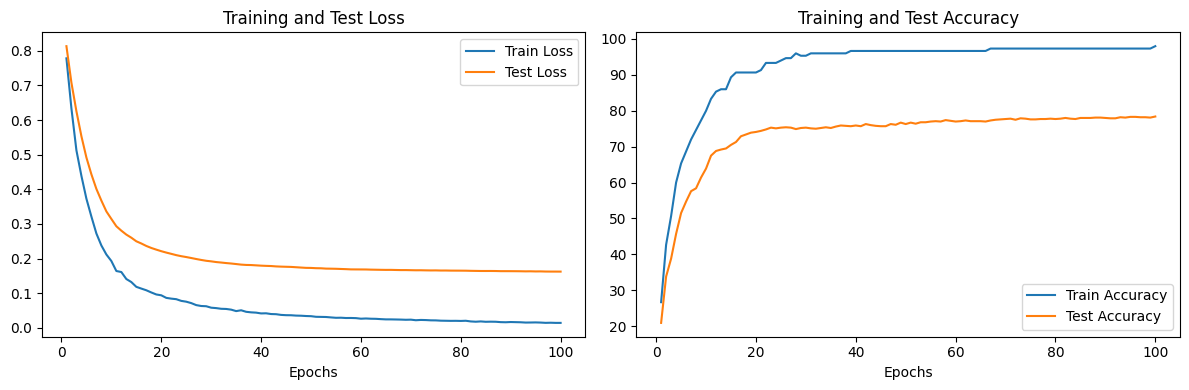

In [324]:
# Plotting
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

## Part C (10 points):

Weight decay works like regularization. Set weight decay to each of the values (0.1, 1, 10) during defining the SGD optimizer (see  [SGD optimizer documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) for how to do that). Plot the train/test losses and accuracies per epoch. Also report the last epoch results (loss and accuracy for both train and test) . Does weight decay help in this case?Justify the results.


Epoch 01 - Train loss: 0.711141, Train accuracy: 42.67%
         - Test loss: 0.781210, Test accuracy: 29.50%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.578838, Train accuracy: 52.67%
         - Test loss: 0.683272, Test accuracy: 39.10%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.485987, Train accuracy: 61.33%
         - Test loss: 0.606562, Test accuracy: 45.90%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.416787, Train accuracy: 68.67%
         - Test loss: 0.541429, Test accuracy: 51.80%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.351681, Train accuracy: 75.33%
         - Test loss: 0.482231, Test accuracy: 57.60%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.312435, Train accuracy: 78.67%
         - Test loss: 0.437512, Test accuracy: 61.00%
------------------------------

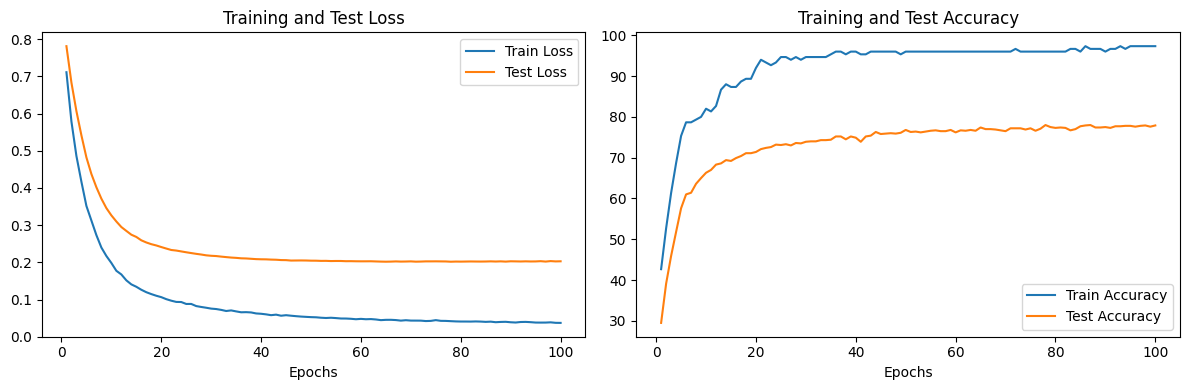

Epoch 01 - Train loss: 0.738352, Train accuracy: 30.00%
         - Test loss: 0.792790, Test accuracy: 19.50%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.616812, Train accuracy: 42.00%
         - Test loss: 0.706632, Test accuracy: 27.20%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.528307, Train accuracy: 52.67%
         - Test loss: 0.641519, Test accuracy: 41.20%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.470814, Train accuracy: 62.00%
         - Test loss: 0.582996, Test accuracy: 46.60%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.419544, Train accuracy: 68.67%
         - Test loss: 0.536975, Test accuracy: 50.60%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.376813, Train accuracy: 71.33%
         - Test loss: 0.500736, Test accuracy: 56.30%
------------------------------

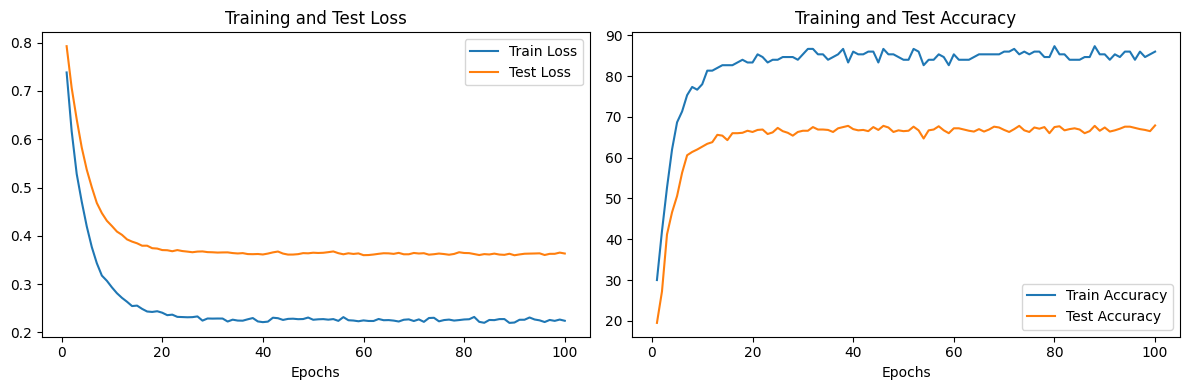

Epoch 01 - Train loss: 0.797534, Train accuracy: 36.00%
         - Test loss: 0.823645, Test accuracy: 27.70%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.749561, Train accuracy: 48.67%
         - Test loss: 0.798135, Test accuracy: 34.80%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.737204, Train accuracy: 42.00%
         - Test loss: 0.786217, Test accuracy: 27.10%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.732721, Train accuracy: 44.67%
         - Test loss: 0.784486, Test accuracy: 32.50%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.733951, Train accuracy: 52.00%
         - Test loss: 0.784336, Test accuracy: 40.60%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.727232, Train accuracy: 32.00%
         - Test loss: 0.786060, Test accuracy: 21.40%
------------------------------

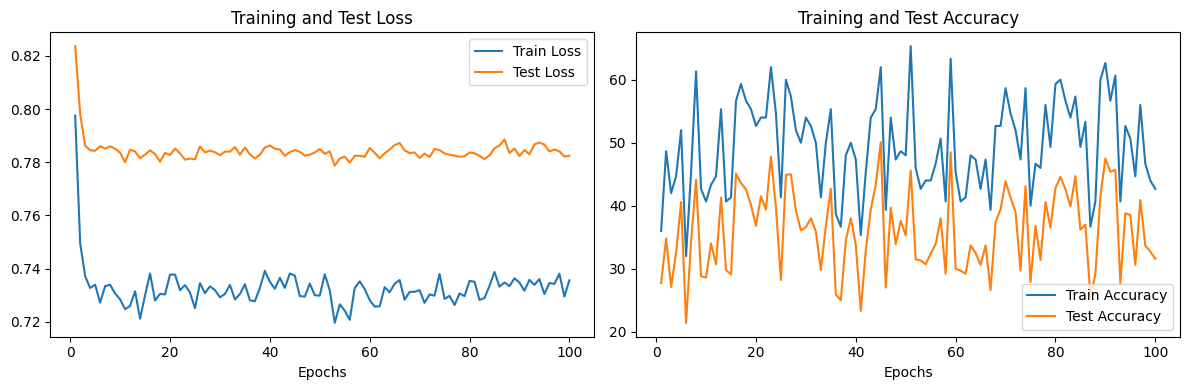

In [325]:
for weight_decay in [0.1, 1, 10]:

    # Initialize the model, loss function, and optimizer
    model = LinearSVM(input_size, num_classes)
    criterion = nn.MultiMarginLoss()  # A Multi-class version of Hinge loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    # Training the model
    for epoch in range(num_epochs):
        for i, (images_batch, labels_batch) in enumerate(train_loader):
            optimizer.zero_grad() # Clear the gradients
            outputs = model(images_batch) # Forward pass
            loss = criterion(outputs, labels_batch) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

        # Obtain train/test loss values and accuracies after each epoch
        train_accuracy, train_loss = eval(model, train_loader, criterion)
        test_accuracy, test_loss = eval(model, test_loader, criterion)

        print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
        print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
        print("-------------------------------------------------------------")

        train_loss_epochs.append(train_loss)
        test_loss_epochs.append(test_loss)
        train_accuracy_epochs.append(train_accuracy)
        test_accuracy_epochs.append(test_accuracy)
    # Plot accuracies
    print(f'For weight decay value {weight_decay}:')
    plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

# Task 2: Logistic Regression for MNIST classification  (20 points).
In this part, you are asked to implement a logistic regression model for the same MNIST classfication problem.

## Part A (5 points):
Use Cross Entropy Loss (rather than Hinge Loss) to implement logistic regression.


## Part B (10 points):
1. Compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number.

2. Compute the cross-entropy loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number.

3. Report the last epoch results (including loss values and accuracies) for both train and test sets.

4. Deos the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?


## Part C (5 points)

Compare the results with SVM model. Does it work better, worse, or similar?

In [326]:
# Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_size, num_classes, bias=True)

    def forward(self, x):
        x= x.view(-1, input_size)
        return torch.sigmoid(self.fc(x))


In [327]:
# Model initialization

model = LogisticRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Train logistic regression model for MNIST classification
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)


    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")


    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

Epoch 01 - Train loss: 2.296785, Train accuracy: 9.33%
         - Test loss: 2.300418, Test accuracy: 9.60%
-------------------------------------------------------------
Epoch 02 - Train loss: 2.286803, Train accuracy: 16.00%
         - Test loss: 2.293449, Test accuracy: 14.00%
-------------------------------------------------------------
Epoch 03 - Train loss: 2.275294, Train accuracy: 21.33%
         - Test loss: 2.286592, Test accuracy: 18.40%
-------------------------------------------------------------
Epoch 04 - Train loss: 2.267733, Train accuracy: 30.67%
         - Test loss: 2.279816, Test accuracy: 23.50%
-------------------------------------------------------------
Epoch 05 - Train loss: 2.257799, Train accuracy: 34.00%
         - Test loss: 2.273286, Test accuracy: 26.70%
-------------------------------------------------------------
Epoch 06 - Train loss: 2.249038, Train accuracy: 38.67%
         - Test loss: 2.266985, Test accuracy: 29.20%
--------------------------------

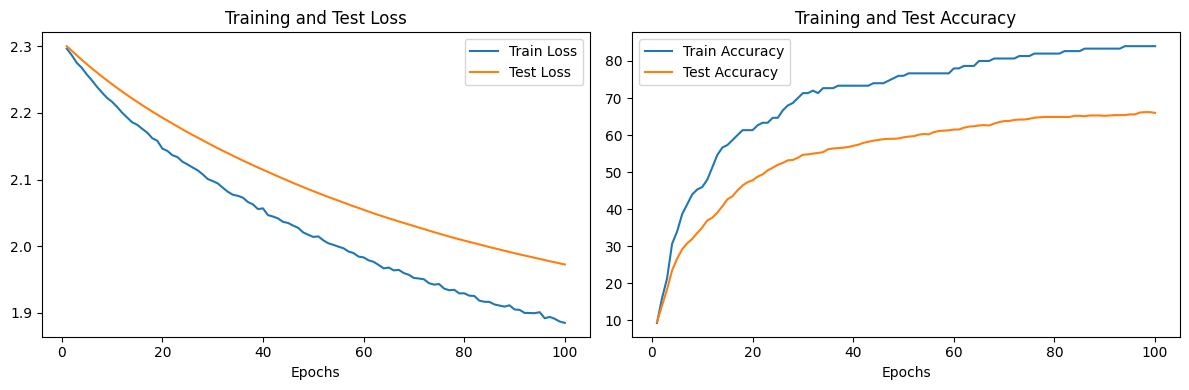

In [328]:
# Plot the loss values and accuracies for train/test
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

# Task 3: Non-linearity (30 points)



## Part A (20 points):

Add a hidden layer with 5000 neurons and a RELU layer for both logistic regression and SVM models in Task 1 and Task 2.
1. For both models, plot the train loss and the test loss.
2. For both models, plot the train and test accuracies.
3. For both models, report the loss and accuracy for both train and test sets.

## Part B (10 Points):

Compare the results with the linear model (without weight decay, to keep the comparison fair). Which approach works better? Why? Which appproach is more prone to overfitting? Explain your findings and justify it.

In [329]:
# Both the SVM and Logistic Regression models we have in Task 1 and 2
# can be changed to the ModifiedModel below.

# Modified model with added neurons and relu layer
class ModifiedModel(nn.Module):
    def __init__(self, input_size, num_classes, use_sigmoid=False):
        super(ModifiedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 5000, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5000, num_classes, bias=True)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = x.view(-1, input_size)    
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.use_sigmoid: 
            return torch.sigmoid(x) 
        return x


In [339]:
# Run the ModifiedModel with Hinge Loss (SVM)
# Model initialization

# Initialize the model, loss function, and optimizer
model = ModifiedModel(input_size, num_classes)
criterion = nn.MultiMarginLoss()  # A Multi-class version of Hinge loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training the model
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)

    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

Epoch 01 - Train loss: 0.742650, Train accuracy: 38.67%
         - Test loss: 0.805804, Test accuracy: 24.40%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.610434, Train accuracy: 38.67%
         - Test loss: 0.718634, Test accuracy: 25.20%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.517265, Train accuracy: 50.67%
         - Test loss: 0.648844, Test accuracy: 36.50%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.433365, Train accuracy: 62.67%
         - Test loss: 0.577723, Test accuracy: 47.40%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.369017, Train accuracy: 72.00%
         - Test loss: 0.514305, Test accuracy: 54.50%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.310821, Train accuracy: 77.33%
         - Test loss: 0.458977, Test accuracy: 57.30%
------------------------------

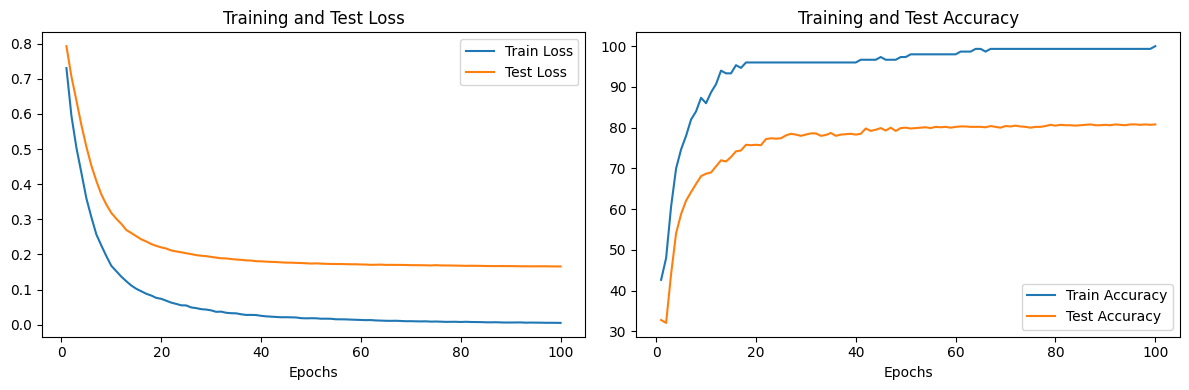

In [331]:
# Plot the loss values and accuracies for train/test
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

In [332]:
# Run the ModifiedModel with Cross Entropy Loss (Logistic Regression)
# Model initialization

model = ModifiedModel(input_size, num_classes, use_sigmoid=True)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training the model
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)

    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)


Epoch 01 - Train loss: 2.290390, Train accuracy: 20.00%
         - Test loss: 2.295979, Test accuracy: 16.00%
-------------------------------------------------------------
Epoch 02 - Train loss: 2.280032, Train accuracy: 23.33%
         - Test loss: 2.289918, Test accuracy: 16.70%
-------------------------------------------------------------
Epoch 03 - Train loss: 2.269599, Train accuracy: 27.33%
         - Test loss: 2.284001, Test accuracy: 17.70%
-------------------------------------------------------------
Epoch 04 - Train loss: 2.261244, Train accuracy: 32.00%
         - Test loss: 2.278178, Test accuracy: 19.30%
-------------------------------------------------------------
Epoch 05 - Train loss: 2.251957, Train accuracy: 33.33%
         - Test loss: 2.272598, Test accuracy: 20.30%
-------------------------------------------------------------
Epoch 06 - Train loss: 2.242498, Train accuracy: 35.33%
         - Test loss: 2.267277, Test accuracy: 22.10%
------------------------------

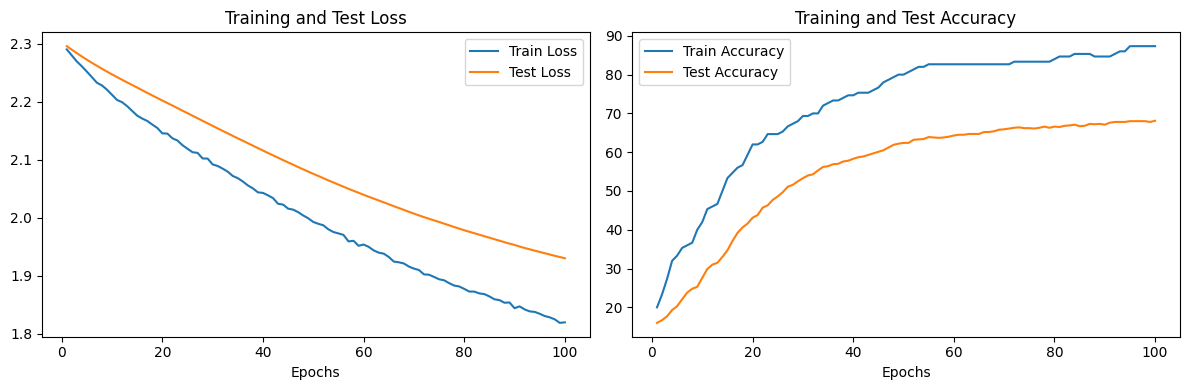

In [333]:
# Plot the loss values and accuracies for train/test
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

# Task 4: Data Augmentation (20 points)

In this task, we will explore the concept of data augmentation, which is a powerful technique used to enhance the diversity of our training dataset without collecting new data. By applying various transformations to the original training images, we can create modified versions of these images.
We can then use these modified images to train our model with a "richer" set of examples.The use of data augmentation helps to improve the robustness and generalization of our models. Data augmentation is particularly beneficial in tasks like image classification, where we expect the model to be invariant to slight variations of images (e.g., rotation, cropping, blurring, etc.)

For this task, you are given a code that uses Gaussian Blur augmentation, which applies a Gaussian filter to slightly blur the images. If you run the code, you will see that this type of augmentation actually makes the model less accurate (compared with Task 3, SVM test accuracy)

For this task, you must explore other types of data augmentation and find one that improves the test accuracy by at least 1 percent compared with not using any augmentation (i.e., compared with Task 3, SVM test accuracy). Only change the augmentation approach, and keep the other parts of the code unchanged. Read the PyTorch documentation on different augmentation techniques [here](https://pytorch.org/vision/stable/transforms.html), and then try to identify a good augmentation method from them. Report the augmentation approach that you used, and explain why you think it helps. Also include train/test accuracy plots per epoch, and the train/test accuracy at the final epoch.


Even if you find that your method does not improve upon the previous task, submit whatever you have completed to get partial marks.




In [334]:
# TRANSFOMATION
# transform = transforms.Compose([
#     transforms.GaussianBlur(kernel_size=3),
#     transforms.ToTensor()
# ])

transform = transforms.Compose([
    transforms.RandomAdjustSharpness(2),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

train_loader_2, test_loader_2 = get_data_loaders(train_data_percentage, test_data_percentage, batch_size, transform)

In [341]:
# Run the ModifiedModel with Hinge Loss (SVM)
# Model initialization

# Initialize the model, loss function, and optimizer
model = ModifiedModel(input_size, num_classes)
criterion = nn.MultiMarginLoss()  # A Multi-class version of Hinge loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training the model
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader_2):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = eval(model, train_loader_2, criterion)
    test_accuracy, test_loss = eval(model, test_loader_2, criterion)

    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

Epoch 01 - Train loss: 0.798307, Train accuracy: 24.00%
         - Test loss: 0.805660, Test accuracy: 27.70%
-------------------------------------------------------------
Epoch 02 - Train loss: 0.698802, Train accuracy: 40.00%
         - Test loss: 0.717946, Test accuracy: 39.20%
-------------------------------------------------------------
Epoch 03 - Train loss: 0.602779, Train accuracy: 49.33%
         - Test loss: 0.639697, Test accuracy: 43.40%
-------------------------------------------------------------
Epoch 04 - Train loss: 0.525809, Train accuracy: 50.67%
         - Test loss: 0.573537, Test accuracy: 44.00%
-------------------------------------------------------------
Epoch 05 - Train loss: 0.467844, Train accuracy: 57.33%
         - Test loss: 0.513419, Test accuracy: 50.00%
-------------------------------------------------------------
Epoch 06 - Train loss: 0.413147, Train accuracy: 70.67%
         - Test loss: 0.455971, Test accuracy: 59.30%
------------------------------

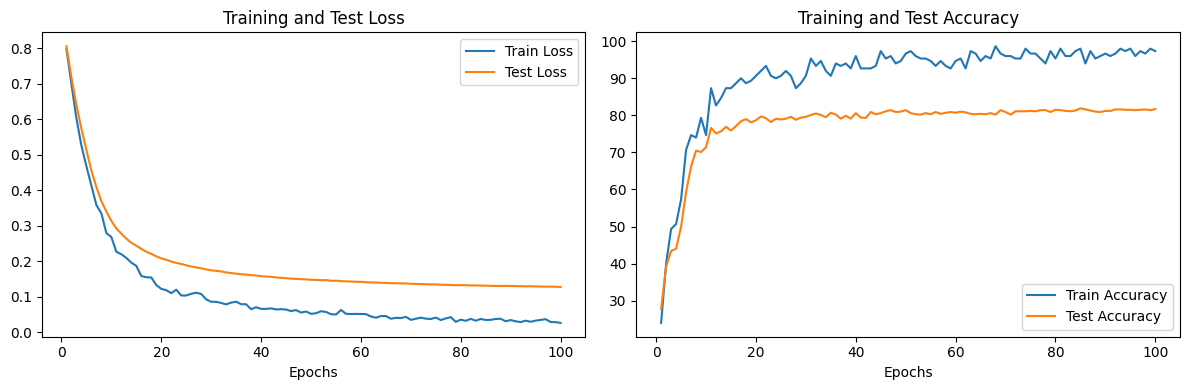

In [342]:
# Plot the loss values and accuracies for train/test
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)